# Multi-Depot Green Vehicle Routing Problem

In this project, we investigate a Multi-Depot Capacitated Green Vehicle Routing Problem (MDCGVRP). Our proposed solution is a variant of the Capacitated Green Vehicle Routing Problem (CGVRP), here we are considering a situation where we have multiple depots. We consider a situation in which distributors who are used to conventionally powered vehicles are faced with the daunting task of managing a fleet of both traditional fueled vehicles and alternatively fueled vehicles. Alternative Fuel-powered vehicles (AFVs) start from the existing warehouses, serve customers and, at the end of the day, return to the original warehouses. The limited travel distance before refueling of AFVs forces them to function within a limited range especially if the distributor does not have the means of providing multiple refueling stations.


<img src="https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-981-10-1837-4_96/MediaObjects/421611_1_En_96_Fig1_HTML.gif" />



The task here is to decide whether for given multiset $N$ of customers, it can be partitioned into two or more subsets $N_{1}$, $N_{2}$, ..., $N_{n}$ such that a given client is as close as possible to a depot. This is done by taking the minimum of the respective the Euclidean distances of customers from the depots. This methodology is better known as the Partition-Based Algorithm (PBA).

## Partition-Based Algorithm (PBA)
The Partition-Based Algorithm (PBA), which is based on the idea of dividing customers into borderline and non-borderline customers, was proposed by Nagy and Salhi (2005) to solve MDGVRP. 

Basically, we consider two types of customers **borderline** and **non_borderline customer**. A borderline customer is a one who is situated approximately halfway between two depots. For instance, consider customer $i$ with the nearest depot $p$ and the second nearest depot $q$. Let $d_{ip}$ and $d_{iq}$ be the distance between customer $i$ and depot $p$ and the distance between customer $i$ and depot $q$, respectively. Customer $i$ is identified as a borderline customer if  $d_{ip}$ $d_{iq}$≥$ra$ ($ra$ is a parameter between 0.5 and 1). Otherwise, customer $i$ is considered as a non-borderline customer. The process of applying the PBA to solve MDGVRP is as follows.

* __Step 1:__ Divide all customers into borderline and non-borderline customers.
* __Step 2:__ Assign all non-borderline customers to their nearest depot.
* __Step 3:__ Generate a GVRP route for each depot and associated non-borderline customers as follows.
    * __Step 3.1:__ Generate TSP (Travelling salesman problem) routes based on nearest neighbor criteria (NNC) (Gutin, Yeo, and Zverovich, 2002) for non-borderline customers is associated with a depot.
    * __Step 3.2:__ Generate GVRP routes from the TSP routes for each depot.
* __Step 4__: Insert the borderline customers into one of the GVRP routes based on the cheapest insertion criteria. If necessary, start a new trip to insert borderline customers.
* __Step 5:__ Use MDGVRP local search for the MDGVRP solution to remove redundant nodes.

Step 3.2 of the algorithm is the most crucial part of the PBA. Generating GVRP route from TSP is obtained in two phases. In the first phase, a VRP route is generated from the TSP route, and, in the second phase, the GVRP route is generated from the VRP route. The process of generating the GVRP route based on the VRP route for a depot k is shown below.

<img src="https://www.mdpi.com/sustainability/sustainability-12-03500/article_deploy/html/images/sustainability-12-03500-g001.png" />

## Code

- $d$ is the number of depots
- $n$ is the number of clients
- $N$ is set of clients, with $N=\{1,2,...,n\}$
- $V$ is set of vetices (or nodes), with $V=\{0\}\cup N$
- $A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$

Then, the formulation is the following
$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

**Importing libraries**

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")
sns.set_context("paper")

import math
import collections
from itertools import compress
from gurobipy import Model, GRB, quicksum # you need to install gurobi for your platform (https://www.gurobi.com/)

Creating our random coordinates with a seed of 2 to ensure it always remains the same.

In [2]:
rnd = np.random
rnd.seed(2)

num_clients = 25   # number of clients
num_depots = 2  # number of depots
C = [i for i in range(1, num_clients+1)]
D = [i for i in range(1, num_depots+1)]

# (x,y) coordinates of our depots
xd = rnd.rand(num_depots)*200
yd = rnd.rand(num_depots)*100

# (x,y) coordinates of our clients
xc = rnd.rand(num_clients)*200
yc = rnd.rand(num_clients)*100

<Figure size 864x864 with 0 Axes>

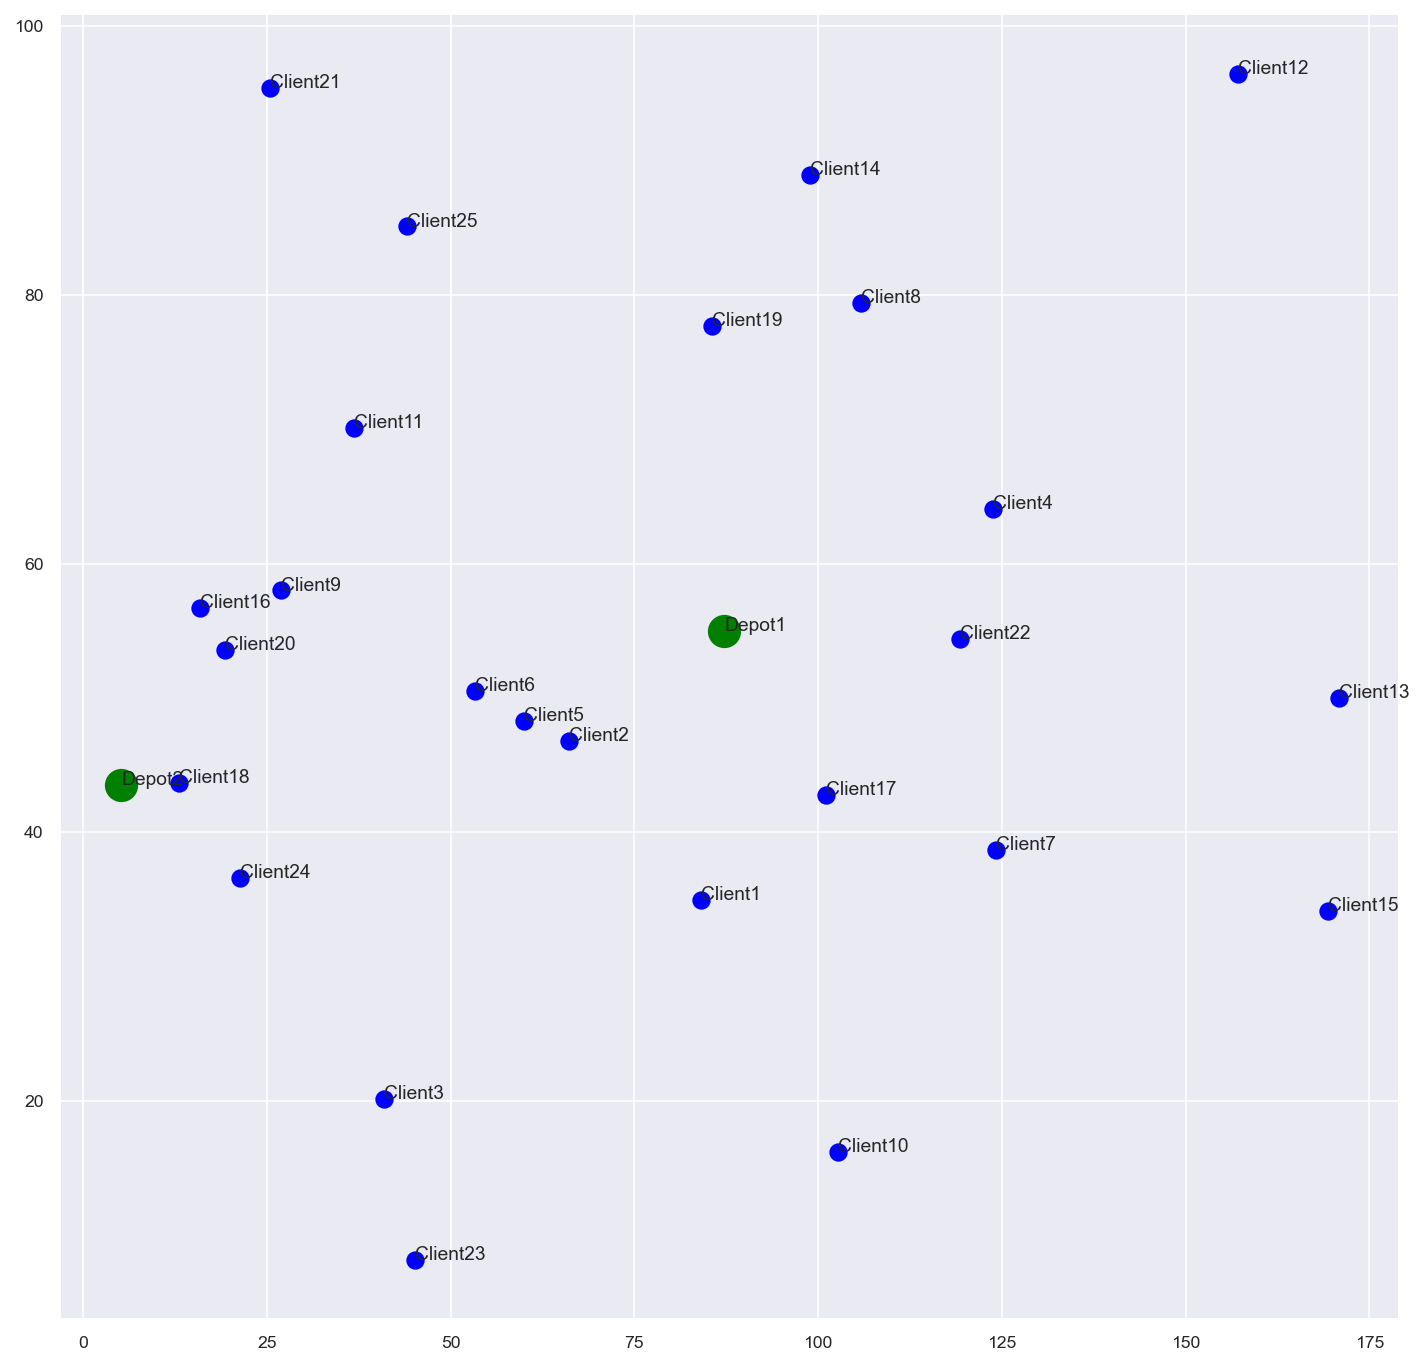

In [3]:
# initial plot of customers and depot
sd=float(250)
sc=float(70)
plt.figure(figsize=(12,12))

# initial plot of customers and depot
plt.figure(figsize=(12,12))
plt.scatter(xd[:], yd[:], c='g', s=sd)
plt.scatter(xc[:], yc[:], c='b', s=sc)

for i, txt in enumerate(D):
    plt.annotate("Depot" + str(txt), (xd[i], yd[i]))
for i, txt in enumerate(C):
    plt.annotate("Client" + str(txt), (xc[i], yc[i]))

Calulating the Eucludiean distance between every client and each deplot

In [4]:
dists = {(i, j): math.sqrt((xc[j]-xd[i])**2 + (yc[j]-yd[i])**2) for i in range(num_depots) for j in range(num_clients)}

# Groups respective distance by depot
def divide(dic, n):
    lst = list(dic)
    p = len(lst) // n
    if len(lst)-p > 0:
        return [lst[:p]] + divide(lst[p:], n-1)
    else:
        return [lst]

dists_keys =divide(dists.keys(), num_depots)
dists_values =divide(dists.values(), num_depots)

In [5]:
# Keeps minimum distance of one client to all depots
df =pd.DataFrame(dists_values)
df =df.where(df.values == df.min(axis=0)[None,:])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,20.226549,22.662684,NaN,37.761751,28.069416,34.123949,40.447461,30.696806,NaN,41.728575,...,NaN,18.464927,NaN,22.744236,NaN,NaN,32.154708,NaN,NaN,52.61185
1,NaN,NaN,42.69965,NaN,NaN,NaN,NaN,NaN,26.106577,NaN,...,17.005881,NaN,7.873344,NaN,17.319504,55.655387,NaN,53.376671,17.611032,NaN


In [6]:
# Keeps valid values to filter coordinates
fill =df.notna().transpose()
df_t =df.transpose()

clients_gby_depots=[]
for i in range(num_depots):
    coords = list(compress(dists_keys[i], fill[i]))
    seconds =  [x[1] for x in coords]
    clients_gby_depots.append(seconds)
    print("Depot ID {} delivers to {} clients {}".format(i, len(coords), [x[1] for x in coords]))

Depot ID 0 delivers to 16 clients [0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18, 21, 24]
Depot ID 1 delivers to 9 clients [2, 8, 10, 15, 17, 19, 20, 22, 23]


In [7]:
clients_gby_depots

[[0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18, 21, 24],
 [2, 8, 10, 15, 17, 19, 20, 22, 23]]

In [8]:
for i in range(num_depots):
    s = {(i, j): np.hypot(xc[j]-xd[i], yc[j]-yd[i]) for j in clients_gby_depots[i]}
    print("Deplot {} | Number of Clients - {} \n".format(i+1, len(s)) + str(s) + "\n")

Deplot 1 | Number of Clients - 16 
{(0, 0): 20.226549139038344, (0, 1): 22.662684199306916, (0, 3): 37.761750657494936, (0, 4): 28.069416026405914, (0, 5): 34.12394937776985, (0, 6): 40.44746111176781, (0, 7): 30.69680550145515, (0, 9): 41.72857517384714, (0, 11): 81.25804460091169, (0, 12): 83.7434151839905, (0, 13): 35.926546019559204, (0, 14): 84.70796837860917, (0, 16): 18.464926558262082, (0, 18): 22.744235625980266, (0, 21): 32.154707707336705, (0, 24): 52.61185035788426}

Deplot 2 | Number of Clients - 9 
{(1, 2): 42.699650485816655, (1, 8): 26.10657716350847, (1, 10): 41.34723072958878, (1, 15): 17.005881051046867, (1, 17): 7.873343939745037, (1, 19): 17.319503772572116, (1, 20): 55.65538652980665, (1, 22): 53.37667142791655, (1, 23): 17.6110323015215}



Grouping x and y coordinates of clients by depots

In [9]:
xz1 = []
xz1.append(xd[0])
xz1 = xz1 + list(xc[i] for i in clients_gby_depots[0])

xz2 = []
xz2.append(xd[1])
xz2 = xz2 + list(xc[i] for i in clients_gby_depots[1])

In [10]:
yz1 = []
yz1.append(yd[0])
yz1 = yz1 + list(yc[i] for i in clients_gby_depots[0])

yz2 = []
yz2.append(yd[1])
yz2 = yz2 + list(yc[i] for i in clients_gby_depots[1])

Considering our problem as TSP for each depot and declaring general variables,

In [11]:
# 
N1 = [i for i in range(1, len(xz1))]
V1 = [0] + N1
A1 = [(i, j) for i in V1 for j in V1 if i != j]
c1 = {(i, j): np.hypot(xz1[i]-xz1[j], yz1[i]-yz1[j]) for i, j in A1}
Q1 = 20
q1 = {i: rnd.randint(1, 10) for i in N1}

# 
N2 = [i for i in range(1, len(xz2))]
V2 = [0] + N2
A2 = [(i, j) for i in V2 for j in V2 if i != j]
c2 = {(i, j): np.hypot(xz2[i]-xz2[j], yz2[i]-yz2[j]) for i, j in A2}
Q2 = 20
q2 = {i: rnd.randint(1, 10) for i in N2}

Setting threshold distance of Green Vehicle

In [12]:
ev_threshold = 100
allowed_travel_distance = ev_threshold/2

__Shortest distance for Green Vehicle i.e Vehicle Range and region__

In [13]:
c_cv1 = c1.copy()
c_cv2 = c2.copy()

od1 = collections.OrderedDict(sorted(c_cv1.items()))
od2 = collections.OrderedDict(sorted(c_cv2.items()))

route1 = {}
route2 = {}

for index, arc in  enumerate(od1):
    from_depot1 = {x: c_cv1[x] for x in c_cv1 if x[0] == index}
    if from_depot1:
        path1 = min(from_depot1, key=from_depot1.get)
        index += path1[1]
        if sum(route1.values()) < allowed_travel_distance:
            route1[path1] = c_cv1[path1]
            _ = c_cv1.pop((path1[1], path1[0]), None)
            _ = c_cv1.pop((path1[0], path1[1]), None)
            
for index, arc in  enumerate(od2):
    from_depot2 = {x: c_cv2[x] for x in c_cv2 if x[0] == index}
    if from_depot2:
        path2 = min(from_depot2, key=from_depot2.get)
        index += path2[1]
        if sum(route2.values()) < allowed_travel_distance:
            route2[path2] = c_cv2[path2]
            _ = c_cv2.pop((path2[1], path2[0]), None)
            _ = c_cv2.pop((path2[0], path2[1]), None)

__Base Variables for Electric Vehicles__

In [14]:
c_ev_11 = {r: route1[r] for r in route1}
c_ev_12 = {r: route2[r] for r in route2}

c_ev_21 = {(r[1],r[0]): route1[r] for r in route1}
c_ev_22 = {(r[1],r[0]): route2[r] for r in route2}

c_ev1 = {**c_ev_11, **c_ev_21}
c_ev2 = {**c_ev_12, **c_ev_22}

ev1 = list(set(y for x in list(c_ev1.keys()) for y in x))
ev2 = list(set(y for x in list(c_ev2.keys()) for y in x))

N_ev1 = ev1[1:]
N_ev2 = ev2[1:]

V_ev1 =  ev1
V_ev2 =  ev2

A_ev1 = [(i, j) for i in V_ev1 for j in V_ev1 if i != j]
A_ev2 = [(i, j) for i in V_ev2 for j in V_ev2 if i != j]

c_ev1 = {(i, j): np.hypot(xz1[i]-xz1[j], yz1[i]-yz1[j]) for i, j in A_ev1}
c_ev2 = {(i, j): np.hypot(xz2[i]-xz2[j], yz2[i]-yz2[j]) for i, j in A_ev2}

Q_ev1 = 20
Q_ev2 = 20

q_ev1 = {i: rnd.randint(1, 10) for i in N_ev1}
q_ev2 = {i: rnd.randint(1, 10) for i in N_ev2}

__Base Variables for Conventional Vehicles__

In [15]:
cv1 = list(set(y for x in list(c_cv1.keys()) for y in x)) 
cv2 = list(set(y for x in list(c_cv2.keys()) for y in x)) 

cv1 = [x for x in cv1 if x not in ev1]
cv2 = [x for x in cv2 if x not in ev2]

N_cv1 = cv1
N_cv2 = cv2

V_cv1 =  [0] + cv1
V_cv2 =  [0] + cv2

A_cv1 = [(i, j) for i in V_cv1 for j in V_cv1 if i != j]
A_cv2 = [(i, j) for i in V_cv2 for j in V_cv2 if i != j]

c_cv1 = {(i, j): np.hypot(xz1[i]-xz1[j], yz1[i]-yz1[j]) for i, j in A_cv1}
c_cv2 = {(i, j): np.hypot(xz2[i]-xz2[j], yz2[i]-yz2[j]) for i, j in A_cv2}

Q_cv1 = 20
Q_cv2 = 20

q_cv1 = {i: rnd.randint(1, 10) for i in N_cv1}
q_cv2 = {i: rnd.randint(1, 10) for i in N_cv2}

## Conventional Vehicles

In [16]:
mdC1 = Model('CVRP')
mdC2 = Model('CVRP')

x_cv1 = mdC1.addVars(A_cv1, vtype=GRB.BINARY)
x_cv2 = mdC2.addVars(A_cv2, vtype=GRB.BINARY)

u_cv1 = mdC1.addVars(N_cv1, vtype=GRB.CONTINUOUS)
u_cv2 = mdC2.addVars(N_cv2, vtype=GRB.CONTINUOUS)

mdC1.modelSense = GRB.MINIMIZE
mdC2.modelSense = GRB.MINIMIZE

mdC1.setObjective(quicksum(x_cv1[i, j]*c_cv1[i, j] for i, j in A_cv1))
mdC2.setObjective(quicksum(x_cv2[i, j]*c_cv2[i, j] for i, j in A_cv2))

Using license file C:\Users\varez\gurobi.lic
Academic license - for non-commercial use only


__Constraints__

In [17]:
mdC1.addConstrs(quicksum(x_cv1[i, j] for j in V_cv1 if j != i) == 1 for i in N_cv1)
mdC2.addConstrs(quicksum(x_cv2[i, j] for j in V_cv2 if j != i) == 1 for i in N_cv2)

mdC1.addConstrs(quicksum(x_cv1[i, j] for i in V_cv1 if i != j) == 1 for j in N_cv1)
mdC2.addConstrs(quicksum(x_cv2[i, j] for i in V_cv2 if i != j) == 1 for j in N_cv2)

mdC1.addConstrs((x_cv1[i, j] == 1) >> (u_cv1[i]+q_cv1[j] == u_cv1[j]) for i, j in A_cv1 if i != 0 and j != 0)
mdC2.addConstrs((x_cv2[i, j] == 1) >> (u_cv2[i]+q_cv2[j] == u_cv2[j]) for i, j in A_cv2 if i != 0 and j != 0)

mdC1.addConstrs(u_cv1[i] >= q1[i] for i in N_cv1)
mdC2.addConstrs(u_cv2[i] >= q2[i] for i in N_cv2)

mdC1.addConstrs(u_cv1[i] <= Q_ev1 for i in N_cv1)
mdC2.addConstrs(u_cv2[i] <= Q_ev2 for i in N_cv2)

{7: <gurobi.Constr *Awaiting Model Update*>}

__Optimization Parameters__

In [18]:
mdC1.Params.MIPGap = 0.1
mdC2.Params.MIPGap = 0.1

mdC1.Params.TimeLimit = 30  # seconds
mdC2.Params.TimeLimit = 30  # seconds

mdC1.optimize()
mdC2.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0xe75185cd
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve added 205 rows and 25 columns
Presolve time: 0.02s
Presolved: 245 rows, 145 columns, 1354 nonzeros
Variable types: 55 continuous, 90 integer (90 binary)

Root relaxation: objective 3.593441e+02, 55 iterations, 0.00 seconds

 

In [19]:
active_arcs1 = [a for a in A_cv1 if x_cv1[a].x > 0.99]
active_arcs2 = [a for a in A_cv2 if x_cv2[a].x > 0.99]

__Conventional Vehicle Model Plot__

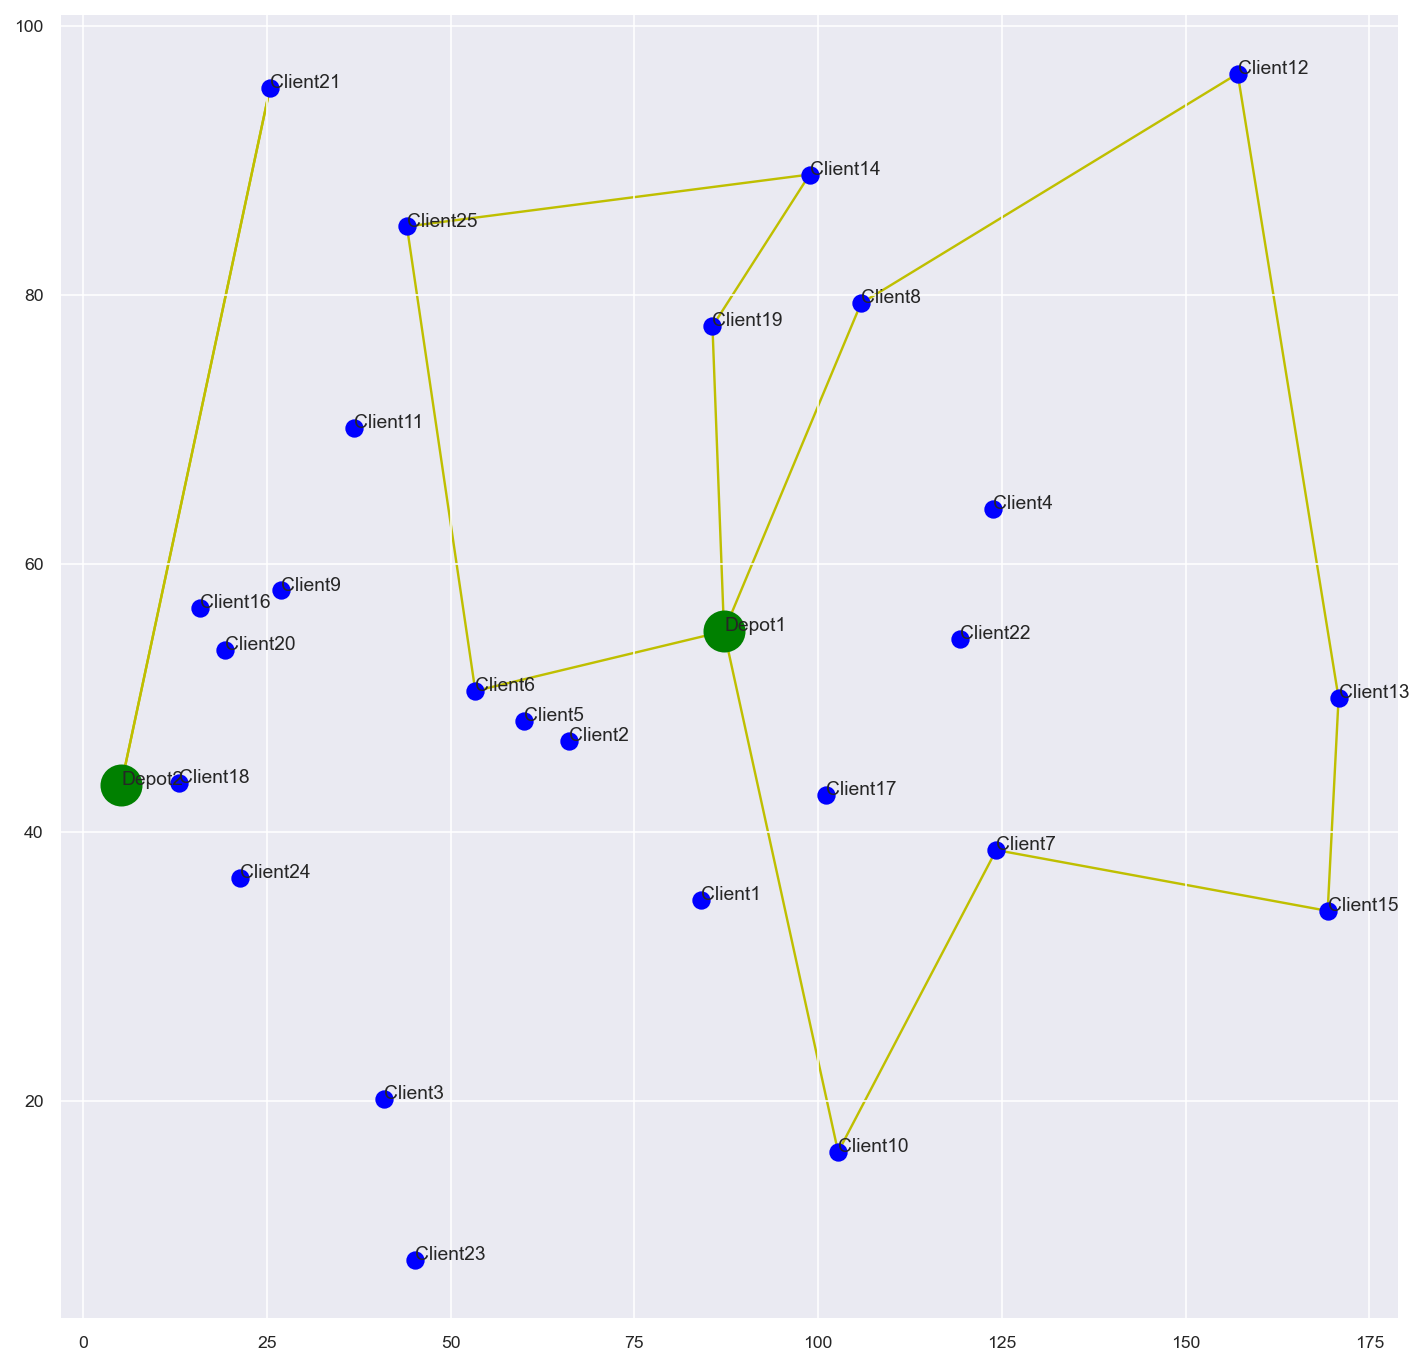

In [27]:
plt.figure(figsize=(12,12))
for i, j in active_arcs1:
    plt.plot([xz1[i], xz1[j]], [yz1[i], yz1[j]], c='y', zorder=0)

for i, j in active_arcs2:
    plt.plot([xz2[i], xz2[j]], [yz2[i], yz2[j]], c='y', zorder=0)

plt.plot(xz1[0], yz1[0], c='g', marker="o", markersize=20.0)
plt.plot(xz2[0], yz2[0], c='g', marker="o", markersize=20.0)

plt.scatter(xz1[1:], yz1[1:], c='b', s=sc)
plt.scatter(xz2[1:], yz2[1:], c='b', s=sc)

for i, txt in enumerate(D):
    plt.annotate("Depot" + str(txt), (xd[i], yd[i]))
for i, txt in enumerate(C):
    plt.annotate("Client" + str(txt), (xc[i], yc[i]))

##  Electric Vehicles

In [21]:
mdE1 = Model('CVRP')
x_ev1 = mdE1.addVars(A_ev1, vtype=GRB.BINARY)
u_ev1 = mdE1.addVars(N_ev1, vtype=GRB.CONTINUOUS)
mdE1.modelSense = GRB.MINIMIZE
mdE1.setObjective(quicksum(x_ev1[i, j]*c_ev1[i, j] for i, j in A_ev1))


mdE2 = Model('CVRP')
x_ev2 = mdE2.addVars(A_ev2, vtype=GRB.BINARY)
u_ev2 = mdE2.addVars(N_ev2, vtype=GRB.CONTINUOUS)
mdE2.modelSense = GRB.MINIMIZE
mdE2.setObjective(quicksum(x_ev2[i, j]*c_ev2[i, j] for i, j in A_ev2))

__Constraints__

In [22]:
mdE1.addConstrs(quicksum(x_ev1[i, j] for j in V_ev1 if j != i) == 1 for i in N_ev1)
mdE1.addConstrs(quicksum(x_ev1[i, j] for i in V_ev1 if i != j) == 1 for j in N_ev1)
mdE1.addConstrs((x_ev1[i, j] == 1) >> (u_ev1[i]+q_ev1[j] == u_ev1[j])
               for i, j in A_ev1 if i != 0 and j != 0)
mdE1.addConstrs(u_ev1[i] >= q_ev1[i] for i in N_ev1)
mdE1.addConstrs(u_ev1[i] <= Q_ev1 for i in N_ev1)


mdE2.addConstrs(quicksum(x_ev2[i, j] for j in V_ev2 if j != i) == 1 for i in N_ev2)
mdE2.addConstrs(quicksum(x_ev2[i, j] for i in V_ev2 if i != j) == 1 for j in N_ev2)
mdE2.addConstrs((x_ev2[i, j] == 1) >> (u_ev2[i]+q_ev2[j] == u_ev2[j])
               for i, j in A_ev2 if i != 0 and j != 0)
mdE2.addConstrs(u_ev2[i] >= q_ev2[i] for i in N_ev2)
mdE2.addConstrs(u_ev2[i] <= Q_ev2 for i in N_ev2)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>}

__Optimization Parameters__

In [23]:
mdE1.Params.MIPGap = 0.1
mdE1.Params.TimeLimit = 30  # seconds
mdE1.optimize()

mdE2.Params.MIPGap = 0.1
mdE2.Params.TimeLimit = 30  # seconds
mdE2.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 24 rows, 48 columns and 84 nonzeros
Model fingerprint: 0x742e6dcf
Model has 30 general constraints
Variable types: 6 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve added 63 rows and 3 columns
Presolve time: 0.00s
Presolved: 87 rows, 51 columns, 375 nonzeros
Variable types: 21 continuous, 30 integer (30 binary)

Root relaxation: objective 1.189456e+02, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  118.94560    0   12          -  

In [24]:
active_arcs_electric_route1 = [a for a in A_ev1 if x_ev1[a].x > 0.99]
active_arcs_electric_route2 = [a for a in A_ev2 if x_ev2[a].x > 0.99]

__Electric Vehicle Model Plot__

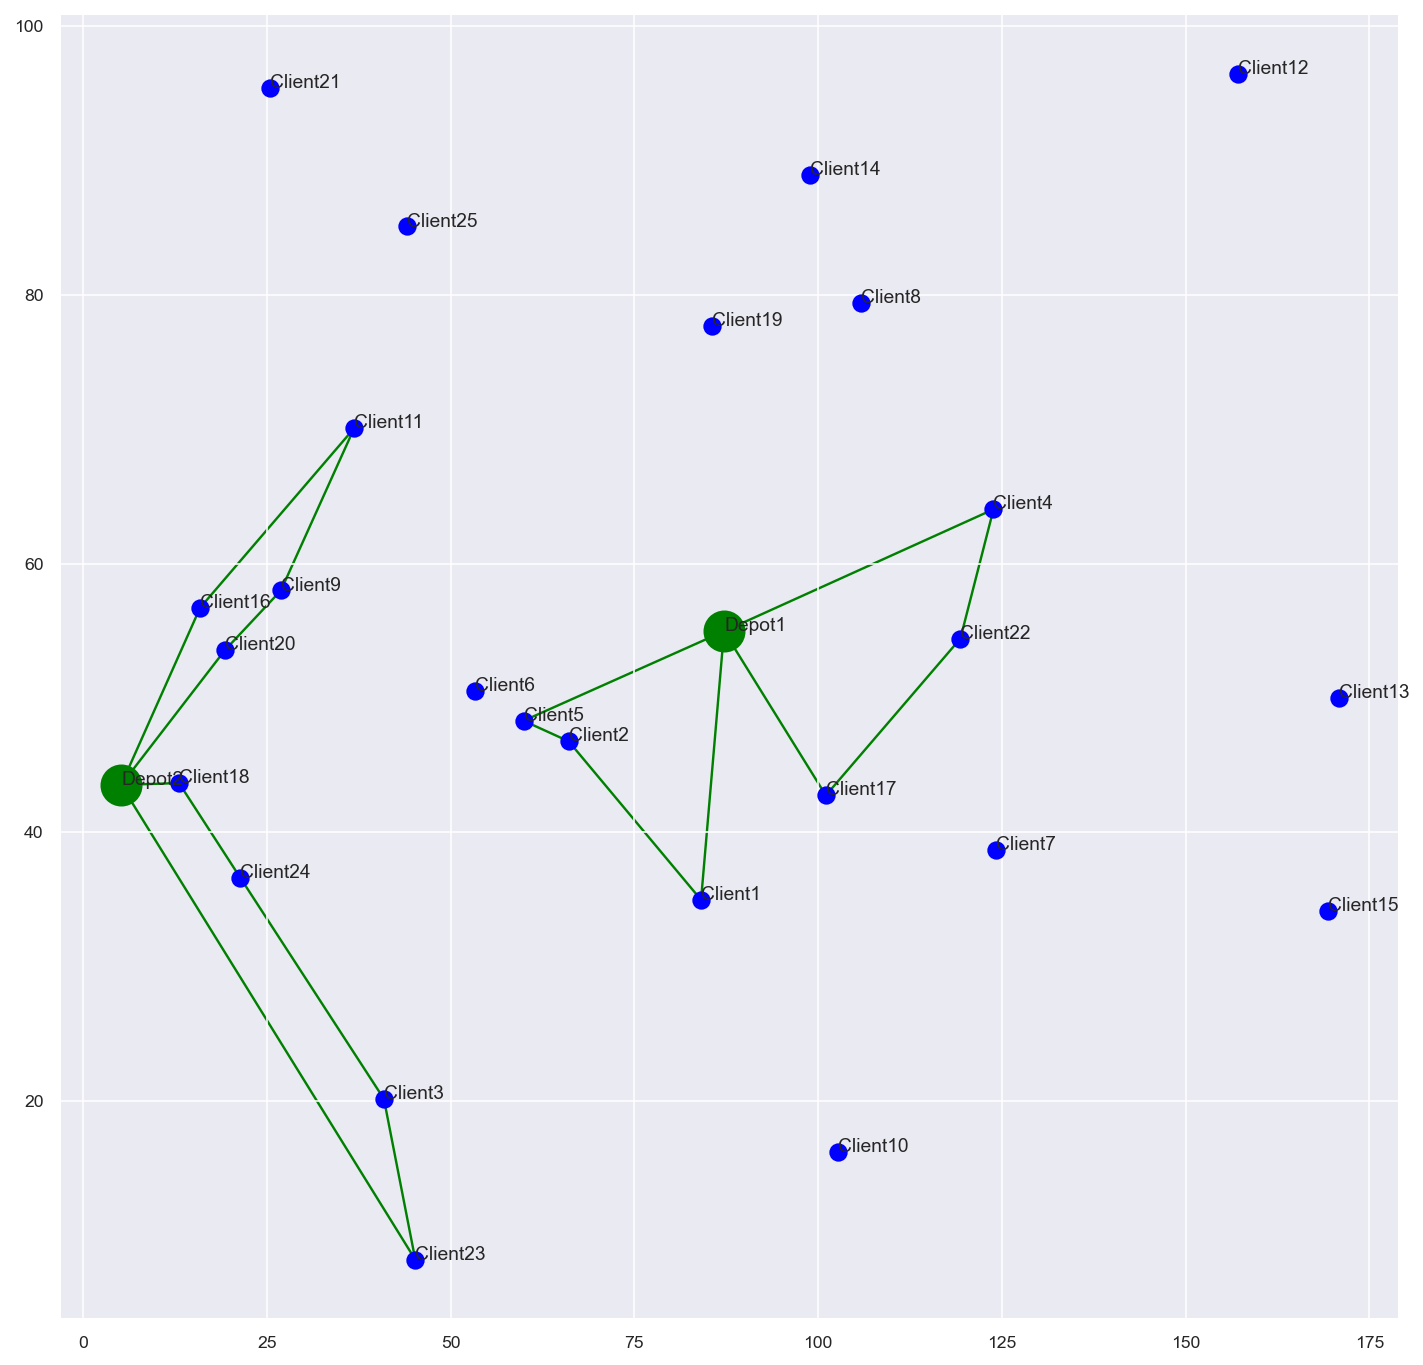

In [26]:


plt.figure(figsize=(12,12))
for i, j in active_arcs_electric_route1:
    plt.plot([xz1[i], xz1[j]], [yz1[i], yz1[j]], c='g', zorder=0)
    
for i, j in active_arcs_electric_route2:
    plt.plot([xz2[i], xz2[j]], [yz2[i], yz2[j]], c='g', zorder=0)
    
plt.plot(xz1[0], yz1[0], c='g', marker="o", markersize=20.0)
plt.plot(xz2[0], yz2[0], c='g', marker="o", markersize=20.0)

plt.scatter(xz1[1:], yz1[1:], c='b', s=sc)
plt.scatter(xz2[1:], yz2[1:], c='b', s=sc)

for i, txt in enumerate(D):
    plt.annotate("Depot" + str(txt), (xd[i], yd[i]))
for i, txt in enumerate(C):
    plt.annotate("Client" + str(txt), (xc[i], yc[i]))